# target encoder & ohe & DeepFM - basic

In [1]:
%load_ext autoreload
%autoreload 2

import os
import warnings
warnings.filterwarnings('ignore')

import sys
sys.path.append(os.path.abspath('..'))
# ---------------------------------
from time import sleep
import numpy as np
import pandas as pd
import scipy
import tqdm
import tensorflow as tf
from tensorflow.keras.layers import Activation
import matplotlib.pyplot as plt

from category_encoders import TargetEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LogisticRegression, SGDRegressor
from sklearn.metrics import roc_auc_score

from hyperopt import hp
# ---------------------------------
from tools import CV, Tuning, CVGetScore, IdxValEncoder, deepfm, CyclicLR, MaxLrFinder
# ---------------------------------
from tools import focal_loss, gelu, mish
from tensorflow.keras.utils import get_custom_objects

get_custom_objects().update({'focal_loss': focal_loss()})
get_custom_objects().update({'mish': mish})
get_custom_objects().update({'gelu': gelu})

In [2]:
train_df = pd.read_csv('../data/train.csv', index_col='id')
test_df = pd.read_csv('../data/test.csv', index_col='id')

# ord_5
for i in range(2):
    train_df[f'ord_5_{i}'] = train_df['ord_5'].str[i]
    test_df[f'ord_5_{i}'] = test_df['ord_5'].str[i]

# null
train_df['null'] = train_df.isna().sum(axis=1)
test_df['null'] = test_df.isna().sum(axis=1)

for col in test_df.columns:
    train_df[col].fillna('isnull', inplace=True)
    test_df[col].fillna('isnull', inplace=True)

# target
target = train_df['target']
y_train = target.values

# drop
train_df.drop(['target', 'ord_5'], axis=1, inplace=True)
test_df.drop(['ord_5'], axis=1, inplace=True)

In [3]:
feature_col = train_df.columns

bin_col = ['null']

class_col = ['bin_0', 'bin_1', 'bin_2', 'bin_3', 'bin_4',
             'nom_0', 'nom_1', 'nom_2', 'nom_3', 'nom_4',
             'nom_5', 'nom_6', 'nom_7', 'nom_8', 'nom_9',
             'ord_0', 'ord_1', 'ord_2', 'ord_3', 'ord_4',
             'day', 'month', 'ord_5_0', 'ord_5_1']

In [4]:
# for col in bin_col:
#     map_dict = dict(zip(train_df[col].unique(), [0., 1.]))
#     train_df[col] = train_df[col].map(map_dict)
#     test_df[col] = test_df[col].map(map_dict)

In [5]:
ecd = IdxValEncoder(feature_col, bin_col=bin_col, class_col=class_col)
ecd.fit(train_df, verbose=1)

600000it [00:11, 51974.72it/s]


In [6]:
ecd.fit(test_df, verbose=1)

400000it [00:07, 52811.24it/s]


In [7]:
idx, val = ecd.transform(train_df, verbose=1)
idx_test, val_test = ecd.transform(test_df, verbose=1)

600000it [00:15, 38602.21it/s]
400000it [00:09, 43771.46it/s]


# Search Max LR

In [67]:
%%time

batch_size = 8192
epochs = 10
nflold = 5

model_param = {'vocabulary_size':ecd.get_vocabulary(), 
               'feature_number': len(feature_col),
               'activation': 'sigmoid',
               'metrics': ['AUC'],
               'optimizer': 'Adam',
               'loss': 'binary_crossentropy',
               'use_fm': False,
               'l1_deep': 0., 'l2_deep': 0., 'use_deep': True}

mf = MaxLrFinder(1e-7, 1e-1, epochs=epochs, batch_size=batch_size, sample_length=train_df.shape[0]*((nflold-1)/nflold))
fit_param = {'batch_size': batch_size, 'epochs':epochs, 'verbose': 0, 'callbacks':[mf]}

model = deepfm(**model_param)

cv = CV(model, nflold)

score = cv.fit(x=[idx, val],
               y=y_train, 
               metrics_func=roc_auc_score,
               split_method=StratifiedKFold,
               fit_params=fit_param,
               eval_param={'batch_size':batch_size},
               use_proba=False, 
               verbose=True,
               fit_use_valid=True)

tf.keras.backend.clear_session()

Train on 480000 samples, validate on 120000 samples
Epoch 1/10
480000/480000 [==============================] - 3s 6us/sample - loss: 0.6912 - AUC: 0.5040 - val_loss: 0.6911 - val_AUC: 0.5037
Epoch 2/10
480000/480000 [==============================] - 2s 4us/sample - loss: 0.6910 - AUC: 0.5043 - val_loss: 0.6908 - val_AUC: 0.5044
Epoch 3/10
480000/480000 [==============================] - 2s 4us/sample - loss: 0.6903 - AUC: 0.5048 - val_loss: 0.6896 - val_AUC: 0.5062
Epoch 4/10
480000/480000 [==============================] - 2s 4us/sample - loss: 0.6876 - AUC: 0.5054 - val_loss: 0.6842 - val_AUC: 0.5077
Epoch 5/10
480000/480000 [==============================] - 2s 4us/sample - loss: 0.6734 - AUC: 0.5076 - val_loss: 0.6487 - val_AUC: 0.5268
Epoch 6/10
480000/480000 [==============================] - 2s 4us/sample - loss: 0.5408 - AUC: 0.5159 - val_loss: 0.4686 - val_AUC: 0.6755
Epoch 7/10
480000/480000 [==============================] - 2s 4us/sample - loss: 0.4314 - AUC: 0.7400 - val

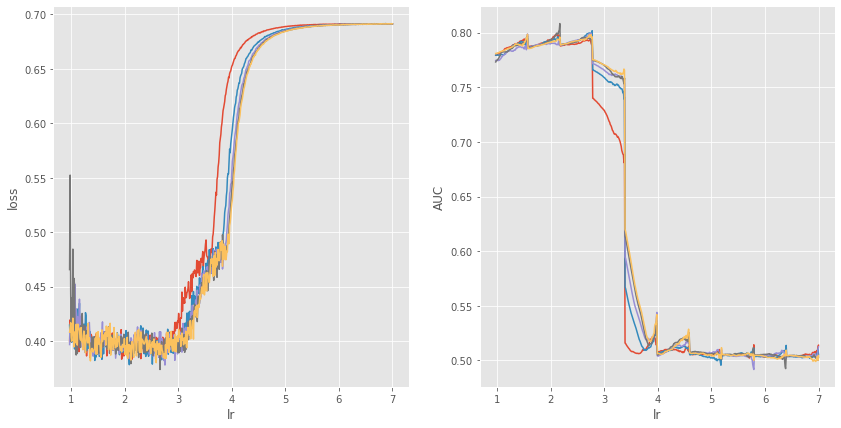

In [69]:
mf.plot(True)

# fit one

In [8]:
%%time

batch_size = 8192
epochs = 100
nflod = 5

model_param = {'vocabulary_size':ecd.get_vocabulary(), 
               'feature_number': len(feature_col),
               'activation': 'sigmoid',
               'metrics': ['AUC'],
               'optimizer': 'Adam',
               'loss': 'binary_crossentropy',
               'use_fm': False, 
               'l1_deep': 0., 'l2_deep': 0., 'use_deep': True,
               'deep_activation': 'relu'}

clr = CyclicLR(base_lr=1e-5,
               max_lr = 1e-3, 
               step_size= int(4.0*(train_df.shape[0]*((nflod-1)/nflod)) / batch_size),
               mode='exp_range',
               gamma=1.0)

es = tf.keras.callbacks.EarlyStopping(monitor='val_AUC', patience=3, mode='max', restore_best_weights=True)

fit_param = {'batch_size': batch_size, 'epochs':epochs, 'verbose': 1, 'callbacks':[es, clr]}

model = deepfm(**model_param)

cv = CV(model, nflod)

score = cv.fit(x=[idx, val],
               y=y_train, 
               metrics_func=roc_auc_score,
               split_method=StratifiedKFold,
               fit_params=fit_param,
               eval_param={'batch_size':batch_size},
               use_proba=False, 
               verbose=True,
               fit_use_valid=True)

tf.keras.backend.clear_session()

Train on 480000 samples, validate on 120000 samples
Epoch 1/100
480000/480000 [==============================] - 4s 8us/sample - loss: 0.6728 - AUC: 0.4927 - val_loss: 0.6139 - val_AUC: 0.5020
Epoch 2/100
480000/480000 [==============================] - 2s 4us/sample - loss: 0.5055 - AUC: 0.5366 - val_loss: 0.4615 - val_AUC: 0.6976
Epoch 3/100
480000/480000 [==============================] - 2s 4us/sample - loss: 0.4299 - AUC: 0.7533 - val_loss: 0.4040 - val_AUC: 0.7806
Epoch 4/100
480000/480000 [==============================] - 2s 4us/sample - loss: 0.3960 - AUC: 0.7905 - val_loss: 0.3975 - val_AUC: 0.7869
Epoch 5/100
480000/480000 [==============================] - 2s 4us/sample - loss: 0.3909 - AUC: 0.7966 - val_loss: 0.3970 - val_AUC: 0.7868
Epoch 6/100
480000/480000 [==============================] - 2s 4us/sample - loss: 0.3888 - AUC: 0.7993 - val_loss: 0.3975 - val_AUC: 0.7863
Epoch 7/100
480000/480000 [==============================] - 2s 4us/sample - loss: 0.3876 - AUC: 0.800

In [9]:
score

0.7869338171784827

# Tuning

In [8]:
%matplotlib qt5

batch_size = 8192
epochs = 100
nflod = 5

# fit param

clr = CyclicLR(base_lr=1e-5,
               max_lr = 1e-3, 
               step_size= int(4.0*(train_df.shape[0]*((nflod-1)/nflod)) / batch_size),
               mode='exp_range',
               gamma=1.0)

es = tf.keras.callbacks.EarlyStopping(monitor='val_AUC', 
                                      patience=3,
                                      mode='max',
                                      restore_best_weights=True)

fit_param = {
    'batch_size': batch_size, 
    'epochs':epochs, 
    'verbose': 0,
    'callbacks':[es, clr]
}

cv_fit_param = {'fit_params': fit_param, 
                'eval_param': {'batch_size':batch_size},
                'use_proba':False, 
                'fit_use_valid': True}

# model_fix_param & model_search_space
model_fix_param = {'vocabulary_size':ecd.get_vocabulary(), 
                   'feature_number': len(feature_col),
                   'activation': 'sigmoid',
                   'metrics': ['AUC'],
                   'optimizer': 'Adam'}

ss = {
    'loss': (hp.choice, ('MSE', 'binary_crossentropy')), 
    'deep_activation': (hp.choice, ('relu', 'elu', 'selu')),
    'num_neuron': (hp.choice, (32, 64, 128, 256)),
    'num_deep_layer': (hp.choice, (1, 2, 3, 4)),
    'use_fm': (hp.choice, (True, False)),
    'deep_use_bn': (hp.choice, (True, False)),
    'l2_deep': (hp.loguniform, (-20, 0)),
    'l2_pair': (hp.loguniform, (-20, 0)),
    'deep_dropout': (hp.uniform, (0, 0.5)),
    'k': (hp.choice, (5, 8, 10))
}

# cv get score
def neg_auc(y_true, y_pred):
    return - roc_auc_score(y_true, y_pred)

gs = CVGetScore(x=[idx, val],
                y=y_train, 
                metrics_func=neg_auc,
                split_method=StratifiedKFold,
                nfolds=nflod, 
                random_state=2333,
                model=deepfm, 
                cv_fit_params=cv_fit_param, 
                model_fix_params=model_fix_param, 
                model_search_space=ss)

tuning = Tuning(gs, verbose=1)
tuning.fmin(gs.GET_SEARCH_SPACE(), max_evals=100)

new best, eval 1, score -0.784, param {'deep_activation': 'relu', 'deep_dropout': 0.11342657642669407, 'deep_layer': (128, 128), 'deep_use_bn': False, 'k': 8, 'l2_deep': 4.3237551145877846e-06, 'l2_pair': 0.026409752313268857, 'loss': 'MSE', 'use_fm': False}
new best, eval 2, score -0.7872, param {'deep_activation': 'elu', 'deep_dropout': 0.17947617565282858, 'deep_layer': (64, 64), 'deep_use_bn': False, 'k': 10, 'l2_deep': 2.2137628412789834e-05, 'l2_pair': 0.00017815660836920653, 'loss': 'MSE', 'use_fm': False}
new best, eval 6, score -0.7879, param {'deep_activation': 'selu', 'deep_dropout': 0.24153150466942286, 'deep_layer': (128, 128), 'deep_use_bn': False, 'k': 10, 'l2_deep': 0.022631538677378216, 'l2_pair': 0.13167264683390165, 'loss': 'binary_crossentropy', 'use_fm': False}
new best, eval 23, score -0.7879, param {'deep_activation': 'selu', 'deep_dropout': 0.004286032086095987, 'deep_layer': (128, 128), 'deep_use_bn': False, 'k': 8, 'l2_deep': 0.7750105425211812, 'l2_pair': 0.0

{'deep_activation': 2,
 'deep_dropout': 0.06883070027250163,
 'deep_layer': 0,
 'deep_use_bn': 1,
 'k': 0,
 'l2_deep': 8.205243570616525e-05,
 'l2_pair': 0.001790837106034854,
 'loss': 1,
 'use_fm': 0}

In [22]:
tudf = tuning.log.get_log()

In [18]:
tudf.sort_values('score').head(20)

,score,update,usetime,deep_activation,deep_dropout,deep_layer,deep_use_bn,k,l2_deep,l2_pair,loss,use_fm
78,-0.788536,True,92.325092,selu,0.068831,"(64, 64)",False,5,8.205244e-05,0.001791,binary_crossentropy,True
81,-0.788472,False,88.852319,selu,0.229575,"(64, 64)",False,5,1.012842e-06,0.005192,binary_crossentropy,True
83,-0.788453,False,88.271212,selu,0.397851,"(64, 64)",False,5,9.556351e-07,0.007304,binary_crossentropy,True
92,-0.788413,False,103.584539,selu,0.262749,"(64, 64)",False,10,6.318715e-06,0.005088,binary_crossentropy,True
59,-0.788408,True,84.312243,relu,0.033212,"(64, 64)",False,8,4.066501e-04,0.000390,binary_crossentropy,True
67,-0.788370,False,117.808969,relu,0.125134,"(64, 64)",False,5,3.829903e-04,0.001524,binary_crossentropy,True
65,-0.788360,False,87.093936,relu,0.089260,"(64, 64)",False,5,5.544186e-04,0.000358,binary_crossentropy,True
49,-0.788353,True,94.463853,relu,0.084061,"(64, 64)",False,8,1.132029e-08,0.000788,binary_crossentropy,True
86,-0.788329,False,407.746858,selu,0.403166,"(256, 256)",True,5,8.094499e-07,0.074633,binary_crossentropy,True
61,-0.788286,False,91.863996,relu,0.077325,"(64, 64)",False,5,6.369422e-04,0.000420,binary_crossentropy,True


In [20]:
tudf.sort_values('score').tail(20)

,score,update,usetime,deep_activation,deep_dropout,deep_layer,deep_use_bn,k,l2_deep,l2_pair,loss,use_fm
0,-0.783971,True,93.833611,relu,0.113427,"(128, 128)",False,8,4.323755e-06,2.640975e-02,MSE,False
42,-0.783833,False,139.216766,relu,0.094980,"(64, 64)",True,10,1.599352e-07,2.534537e-01,binary_crossentropy,False
85,-0.783689,False,99.659046,selu,0.408328,"(64, 64)",False,5,3.198273e-07,4.163962e-01,binary_crossentropy,True
58,-0.782691,False,101.129662,elu,0.313297,"(64, 64)",False,8,9.338811e-05,5.739413e-02,binary_crossentropy,True
96,-0.781074,False,103.471665,selu,0.412713,"(64, 64)",False,10,3.719644e-06,4.586998e-02,MSE,True
34,-0.780864,False,85.816297,relu,0.163572,"(64, 64)",False,10,1.607237e-05,3.830369e-01,binary_crossentropy,False
19,-0.778559,False,357.504729,selu,0.275691,"(256, 256)",True,5,8.479860e-07,4.912949e-03,binary_crossentropy,True
13,-0.778082,False,291.812761,elu,0.375647,"(256, 256)",True,5,8.632809e-02,2.909387e-06,MSE,True
7,-0.777740,False,180.396082,relu,0.283213,"(128, 128)",True,5,1.193106e-06,2.225319e-01,binary_crossentropy,False
2,-0.776544,False,285.869753,selu,0.170655,"(256, 256)",True,10,9.008251e-05,1.106278e-06,binary_crossentropy,False


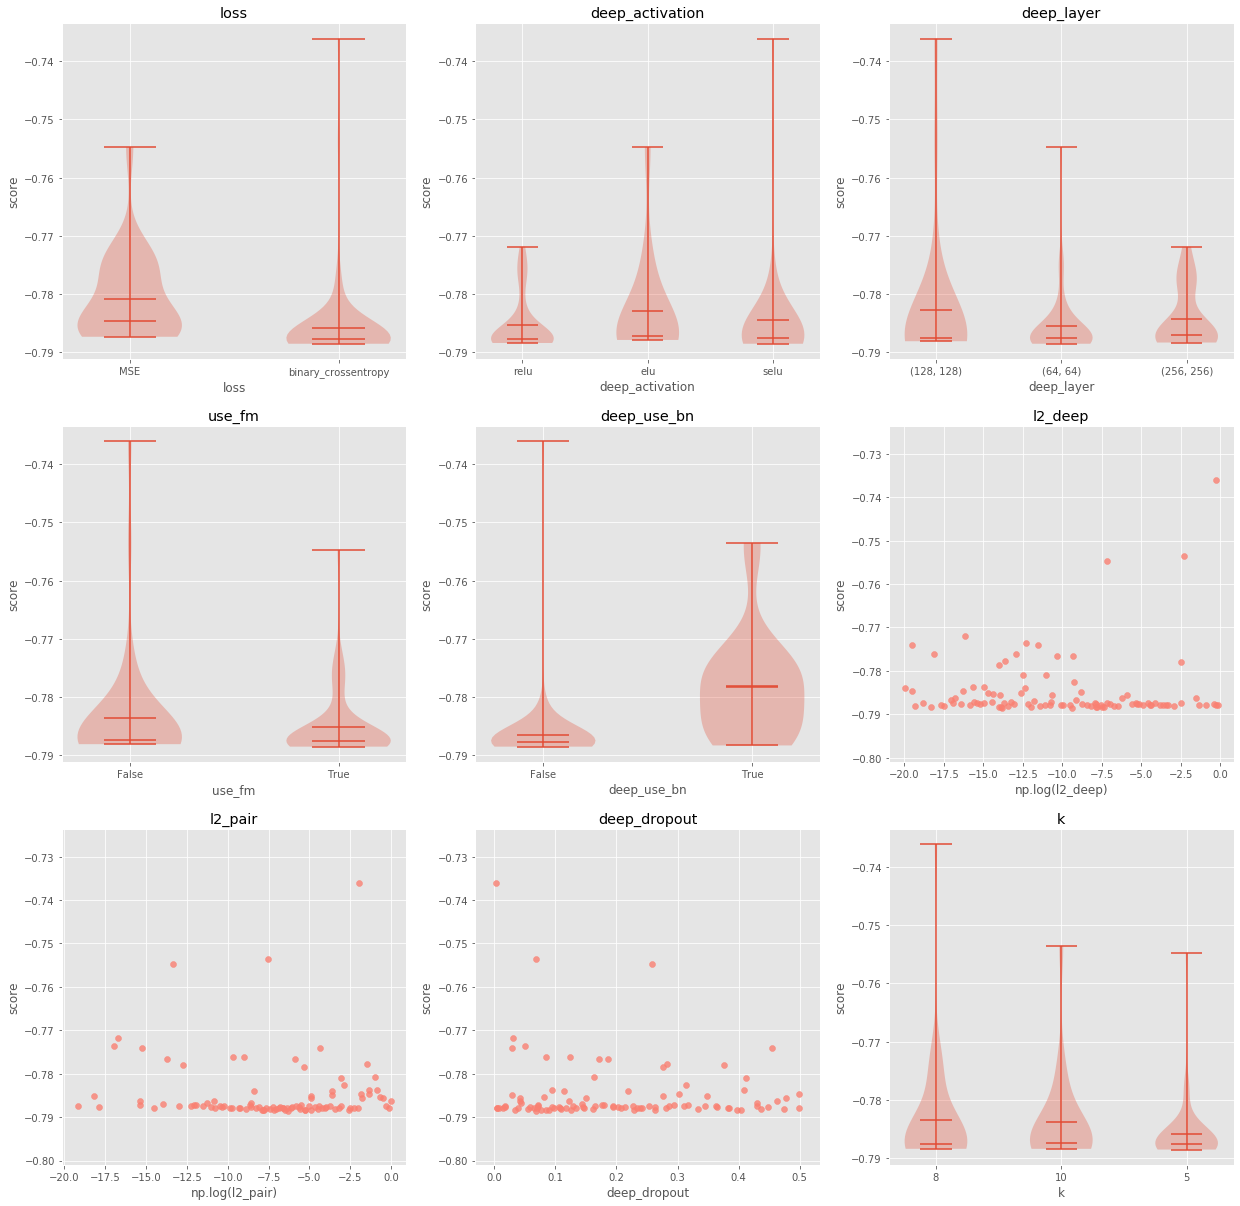

In [24]:
%matplotlib inline
tuning.log.plot()

In [25]:
tuning.log.best_param

{'deep_activation': 'selu',
 'deep_dropout': 0.06883070027250163,
 'deep_layer': (64, 64),
 'deep_use_bn': False,
 'k': 5,
 'l2_deep': 8.205243570616525e-05,
 'l2_pair': 0.001790837106034854,
 'loss': 'binary_crossentropy',
 'use_fm': True}

result：
use_bn == False 
use_fm == True
deep_activation drop elu
loss drop mse

best param:
{'deep_activation': 'selu',
 'deep_dropout': 0.06883070027250163,
 'deep_layer': (64, 64),
 'deep_use_bn': False,
 'k': 5,
 'l2_deep': 8.205243570616525e-05,
 'l2_pair': 0.001790837106034854,
 'loss': 'binary_crossentropy',
 'use_fm': True}

# Tuning 2

In [10]:
%matplotlib qt5

batch_size = 8192
epochs = 100
nflod = 5

# fit param

clr = CyclicLR(base_lr=1e-5,
               max_lr = 1e-3, 
               step_size= int(4.0*(train_df.shape[0]*((nflod-1)/nflod)) / batch_size),
               mode='exp_range',
               gamma=1.0)

es = tf.keras.callbacks.EarlyStopping(monitor='val_AUC', 
                                      patience=3,
                                      mode='max',
                                      restore_best_weights=True)

fit_param = {
    'batch_size': batch_size, 
    'epochs':epochs, 
    'verbose': 0,
    'callbacks':[es, clr]
}

cv_fit_param = {'fit_params': fit_param, 
                'eval_param': {'batch_size':batch_size},
                'use_proba':False, 
                'fit_use_valid': True}

# model_fix_param & model_search_space
model_fix_param = {'vocabulary_size':ecd.get_vocabulary(), 
                   'feature_number': len(feature_col),
                   'activation': 'sigmoid',
                   'metrics': ['AUC'],
                   'use_fm': True,
                   'k': 5,
                   'deep_use_bn': False,
                   'optimizer': 'Adam'}

ss = {
    'loss': (hp.choice, ('focal_loss', 'binary_crossentropy')), 
    'deep_activation': (hp.choice, ('relu', 'mish', 'gelu', 'selu')),
    'num_neuron': (hp.choice, (32, 64, 128, 256)),
    'num_deep_layer': (hp.choice, (1, 2, 3, 4)),
    'l2_deep': (hp.loguniform, (-20, 0)),
    'l2_pair': (hp.loguniform, (-20, 0)),
    'deep_dropout': (hp.uniform, (0, 0.5)),
}

# cv get score
def neg_auc(y_true, y_pred):
    return - roc_auc_score(y_true, y_pred)

gs = CVGetScore(x=[idx, val],
                y=y_train, 
                metrics_func=neg_auc,
                split_method=StratifiedKFold,
                nfolds=nflod, 
                random_state=2333,
                model=deepfm, 
                cv_fit_params=cv_fit_param, 
                model_fix_params=model_fix_param, 
                model_search_space=ss)

tuning = Tuning(gs, verbose=1)
tuning.fmin(gs.GET_SEARCH_SPACE(), max_evals=100)

new best, eval 1, score -0.7882, param {'deep_activation': 'gelu', 'deep_dropout': 0.477036670344579, 'l2_deep': 3.796347248511383e-05, 'l2_pair': 2.6792931614280555e-05, 'loss': 'focal_loss', 'num_deep_layer': 4, 'num_neuron': 128}
new best, eval 8, score -0.7883, param {'deep_activation': 'relu', 'deep_dropout': 0.4031994929304784, 'l2_deep': 3.8445151095747414e-05, 'l2_pair': 0.0003041962565043843, 'loss': 'focal_loss', 'num_deep_layer': 3, 'num_neuron': 256}
new best, eval 15, score -0.7884, param {'deep_activation': 'mish', 'deep_dropout': 0.21228502841204572, 'l2_deep': 3.0898758043234134e-06, 'l2_pair': 0.0003849485846131887, 'loss': 'focal_loss', 'num_deep_layer': 4, 'num_neuron': 256}
new best, eval 86, score -0.7885, param {'deep_activation': 'mish', 'deep_dropout': 0.2767215096238148, 'l2_deep': 9.032689132231908e-06, 'l2_pair': 3.727746700481201e-05, 'loss': 'focal_loss', 'num_deep_layer': 1, 'num_neuron': 32}
100%|██████████| 100/100 [5:39:25<00:00, 203.66s/trial, best los

{'deep_activation': 1,
 'deep_dropout': 0.2767215096238148,
 'l2_deep': 9.032689132231908e-06,
 'l2_pair': 3.727746700481201e-05,
 'loss': 0,
 'num_deep_layer': 0,
 'num_neuron': 0}

In [17]:
tuning.log.get_best_param()

{'deep_activation': 'mish',
 'deep_dropout': 0.2767215096238148,
 'l2_deep': 9.032689132231908e-06,
 'l2_pair': 3.727746700481201e-05,
 'loss': 'focal_loss',
 'num_deep_layer': 1,
 'num_neuron': 32}

In [11]:
tudf = tuning.log.get_log()

In [14]:
tudf.sort_values('score').head(20)

,score,update,usetime,deep_activation,deep_dropout,l2_deep,l2_pair,loss,num_deep_layer,num_neuron
85,-0.788487,True,98.291051,mish,0.276722,9.032689e-06,0.000037,focal_loss,1,32
14,-0.788440,True,237.345217,mish,0.212285,3.089876e-06,0.000385,focal_loss,4,256
7,-0.788320,True,140.007214,relu,0.403199,3.844515e-05,0.000304,focal_loss,3,256
57,-0.788243,False,84.154469,relu,0.402723,1.955755e-05,0.000024,focal_loss,1,32
96,-0.788168,False,122.574362,mish,0.279959,8.822776e-08,0.000555,focal_loss,4,64
0,-0.788150,True,187.693281,gelu,0.477037,3.796347e-05,0.000027,focal_loss,4,128
72,-0.788123,False,135.496011,relu,0.316917,1.104179e-05,0.000204,focal_loss,1,32
65,-0.788115,False,92.277762,relu,0.385183,1.748552e-05,0.000027,focal_loss,1,32
90,-0.788096,False,72.483853,mish,0.196834,7.549311e-09,0.000012,focal_loss,1,32
86,-0.788047,False,135.713502,mish,0.115831,9.356880e-06,0.000040,focal_loss,4,128


In [15]:
tudf.sort_values('score').tail(20)

,score,update,usetime,deep_activation,deep_dropout,l2_deep,l2_pair,loss,num_deep_layer,num_neuron
18,-0.786941,False,58.877863,relu,0.090284,1.067684e-05,1.260665e-07,binary_crossentropy,1,32
75,-0.786769,False,79.284886,mish,0.492212,2.029221e-05,5.763031e-06,focal_loss,3,32
9,-0.786409,False,138.960573,relu,0.098835,2.210230e-05,2.061918e-03,focal_loss,2,32
79,-0.786321,False,155.317127,mish,0.185797,6.799917e-04,5.124984e-08,focal_loss,2,128
87,-0.786264,False,187.213085,mish,0.294906,4.018587e-08,7.157342e-03,focal_loss,2,256
24,-0.786237,False,145.645353,relu,0.288717,3.892251e-09,7.823923e-07,focal_loss,3,256
37,-0.786235,False,263.154880,mish,0.494889,2.750325e-05,1.674673e-03,focal_loss,3,256
83,-0.785488,False,118.740561,selu,0.404530,3.602709e-06,5.337797e-02,focal_loss,4,64
8,-0.785484,False,377.055406,gelu,0.037552,1.743309e-02,1.675776e-07,focal_loss,4,256
52,-0.785339,False,158.289011,gelu,0.287918,2.165151e-03,1.381459e-08,focal_loss,1,256


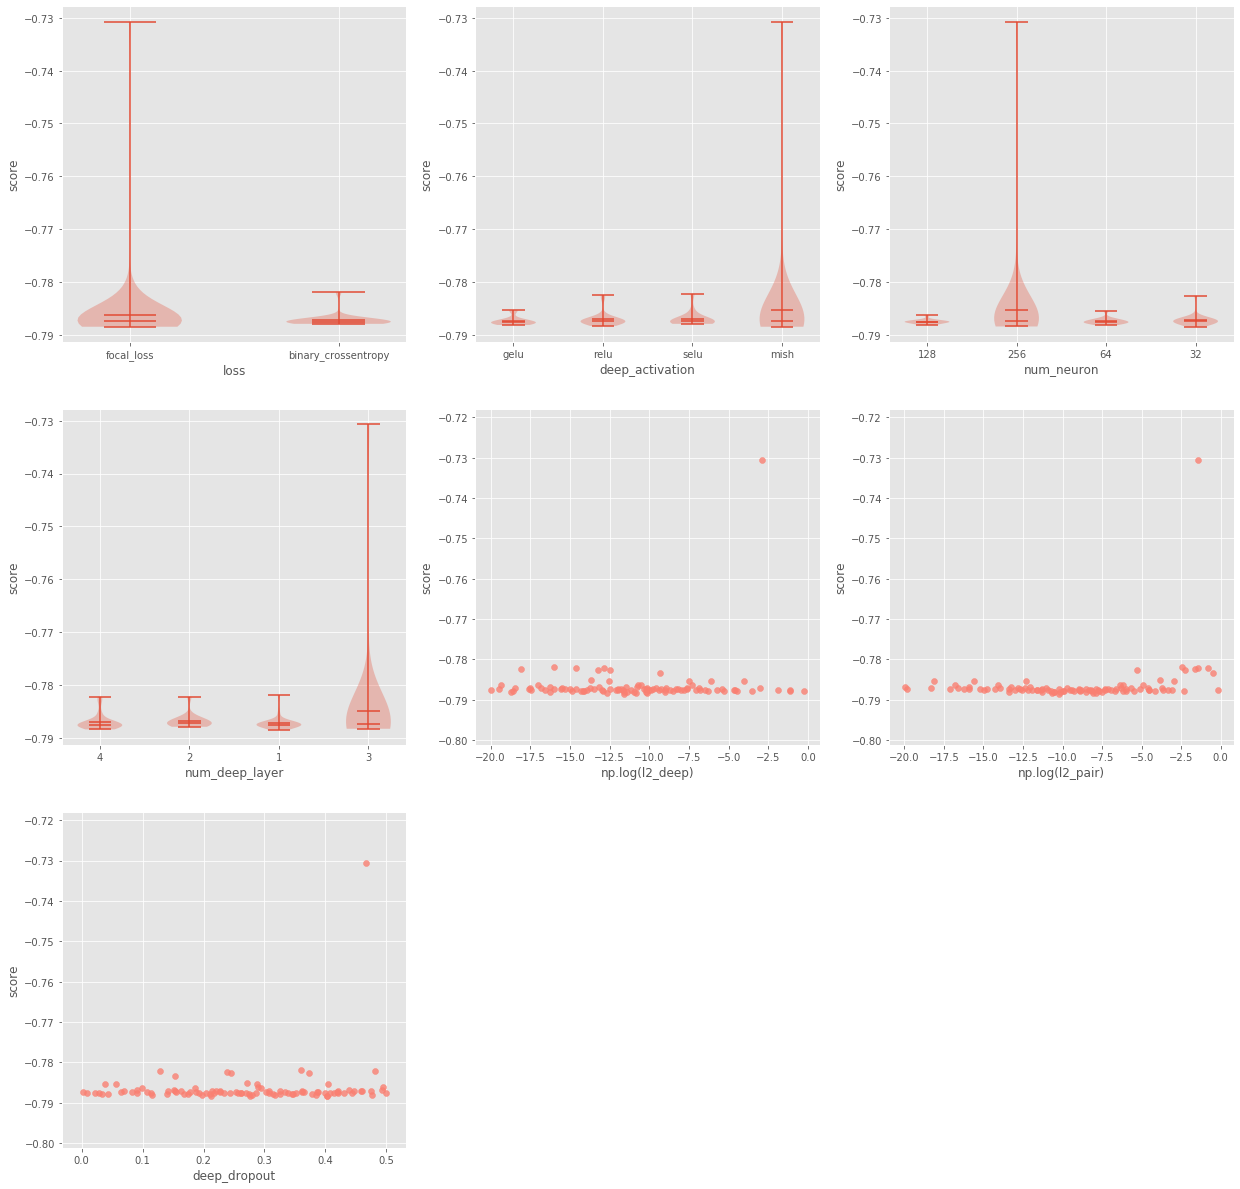

In [16]:
%matplotlib inline
tuning.log.plot()

{'deep_activation': 'mish',
 'deep_dropout': 0.2767215096238148,
 'l2_deep': 9.032689132231908e-06,
 'l2_pair': 3.727746700481201e-05,
 'loss': 'focal_loss',
 'num_deep_layer': 1,
 'num_neuron': 32}

# Tuning 3

In [8]:
%matplotlib qt5

batch_size = 8192
epochs = 100
nflod = 5

# fit param

clr = CyclicLR(base_lr=1e-5,
               max_lr = 1e-3, 
               step_size= int(4.0*(train_df.shape[0]*((nflod-1)/nflod)) / batch_size),
               mode='exp_range',
               gamma=1.0)

es = tf.keras.callbacks.EarlyStopping(monitor='val_AUC', 
                                      patience=3,
                                      mode='max',
                                      restore_best_weights=True)

fit_param = {
    'batch_size': batch_size, 
    'epochs':epochs, 
    'verbose': 0,
    'callbacks':[es, clr]
}

cv_fit_param = {'fit_params': fit_param, 
                'eval_param': {'batch_size':batch_size},
                'use_proba':False, 
                'fit_use_valid': True}

# model_fix_param & model_search_space
model_fix_param = {'vocabulary_size':ecd.get_vocabulary(), 
                   'feature_number': len(feature_col),
                   'activation': 'sigmoid',
                   'metrics': ['AUC'],
                   'use_fm': True,
                   'k': 5,
                   'deep_use_bn': False,
                   'optimizer': 'Adam'}

ss = {
    'loss': (hp.choice, ('focal_loss', 'binary_crossentropy')), 
    'deep_activation': (hp.choice, ('relu', 'mish', 'gelu', 'selu')),
    'num_neuron': (hp.choice, (32, 64, 128, 256)),
    'num_deep_layer': (hp.choice, (1, 2, 3, 4)),
    'l2_deep': (hp.loguniform, (-15, -5)),
    'l2_pair': (hp.loguniform, (-15, -5)),
    'deep_dropout': (hp.uniform, (0, 0.5)),
}

# cv get score
def neg_auc(y_true, y_pred):
    return - roc_auc_score(y_true, y_pred)

gs = CVGetScore(x=[idx, val],
                y=y_train, 
                metrics_func=neg_auc,
                split_method=StratifiedKFold,
                nfolds=nflod, 
                random_state=2333,
                model=deepfm, 
                cv_fit_params=cv_fit_param, 
                model_fix_params=model_fix_param, 
                model_search_space=ss)

tuning = Tuning(gs, verbose=1)
tuning.fmin(gs.GET_SEARCH_SPACE(), max_evals=200)

new best, eval 1, score -0.7878, param {'deep_activation': 'gelu', 'deep_dropout': 0.2139691637169262, 'l2_deep': 0.00010689174556528604, 'l2_pair': 3.9484323012650275e-05, 'loss': 'focal_loss', 'num_deep_layer': 4, 'num_neuron': 128}
new best, eval 7, score -0.788, param {'deep_activation': 'mish', 'deep_dropout': 0.4645470455942855, 'l2_deep': 6.8743241981384e-07, 'l2_pair': 0.0001077609930034187, 'loss': 'focal_loss', 'num_deep_layer': 4, 'num_neuron': 32}
new best, eval 10, score -0.7882, param {'deep_activation': 'relu', 'deep_dropout': 0.3872314333659373, 'l2_deep': 3.8453801351827846e-07, 'l2_pair': 0.0002042903787541435, 'loss': 'binary_crossentropy', 'num_deep_layer': 1, 'num_neuron': 64}
new best, eval 13, score -0.7883, param {'deep_activation': 'selu', 'deep_dropout': 0.2564505387111382, 'l2_deep': 2.2672958405395738e-05, 'l2_pair': 0.004210792822295253, 'loss': 'binary_crossentropy', 'num_deep_layer': 2, 'num_neuron': 256}
new best, eval 16, score -0.7884, param {'deep_act

{'deep_activation': 1,
 'deep_dropout': 0.14131251282671942,
 'l2_deep': 2.7626562843885004e-05,
 'l2_pair': 0.0009439566996232189,
 'loss': 1,
 'num_deep_layer': 0,
 'num_neuron': 1}

In [9]:
tndf = tuning.log.get_log()

{'deep_activation': 'mish',    
 'deep_dropout': 0.14131251282671942,    
 'l2_deep': 2.7626562843885004e-05,   
 'l2_pair': 0.0009439566996232189,   
 'loss': 'binary_crossentropy',   
 'num_deep_layer': 1,   
 'num_neuron': 64}   

In [13]:
tndf.sort_values('score').head(20)

,score,update,usetime,deep_activation,deep_dropout,l2_deep,l2_pair,loss,num_deep_layer,num_neuron
88,-0.788723,True,144.699545,mish,0.141313,0.000028,0.000944,binary_crossentropy,1,64
185,-0.788710,False,181.161174,gelu,0.399505,0.000063,0.000551,binary_crossentropy,1,256
147,-0.788706,False,103.641579,selu,0.472409,0.000118,0.000789,binary_crossentropy,1,64
72,-0.788699,True,90.722424,mish,0.175222,0.000018,0.000994,binary_crossentropy,2,64
158,-0.788668,False,142.750754,selu,0.329640,0.000125,0.001146,binary_crossentropy,1,64
98,-0.788667,False,92.091733,selu,0.226571,0.000079,0.000762,binary_crossentropy,1,64
151,-0.788634,False,108.851004,selu,0.214867,0.000246,0.000557,binary_crossentropy,1,64
107,-0.788633,False,103.684661,selu,0.397568,0.000160,0.000816,binary_crossentropy,1,64
180,-0.788625,False,129.651306,mish,0.033739,0.000165,0.000321,binary_crossentropy,1,128
96,-0.788624,False,81.241957,selu,0.103135,0.000013,0.000782,binary_crossentropy,1,64


In [14]:
tndf.sort_values('score').tail(20)

,score,update,usetime,deep_activation,deep_dropout,l2_deep,l2_pair,loss,num_deep_layer,num_neuron
193,-0.787270,False,287.016531,gelu,0.109092,3.492849e-05,2.284371e-03,focal_loss,1,256
143,-0.787246,False,105.766909,selu,0.286801,5.490758e-05,3.983527e-05,binary_crossentropy,4,64
41,-0.787227,False,324.718314,mish,0.277766,7.625168e-05,6.390899e-03,focal_loss,1,256
104,-0.787223,False,184.621298,selu,0.266957,7.198307e-05,1.467204e-03,focal_loss,1,64
164,-0.787213,False,195.685442,relu,0.390884,3.952980e-04,1.263359e-03,focal_loss,4,64
136,-0.787118,False,113.070659,selu,0.125259,1.228343e-05,4.403319e-06,binary_crossentropy,4,64
57,-0.787114,False,104.926998,relu,0.244595,2.236757e-05,1.405885e-06,binary_crossentropy,2,256
11,-0.787105,False,139.109405,gelu,0.475381,2.359767e-03,9.262890e-07,focal_loss,4,64
14,-0.787102,False,212.159405,selu,0.100458,8.568734e-06,1.364173e-05,binary_crossentropy,4,256
3,-0.787095,False,68.655102,relu,0.365293,1.613110e-05,1.065140e-06,binary_crossentropy,1,64


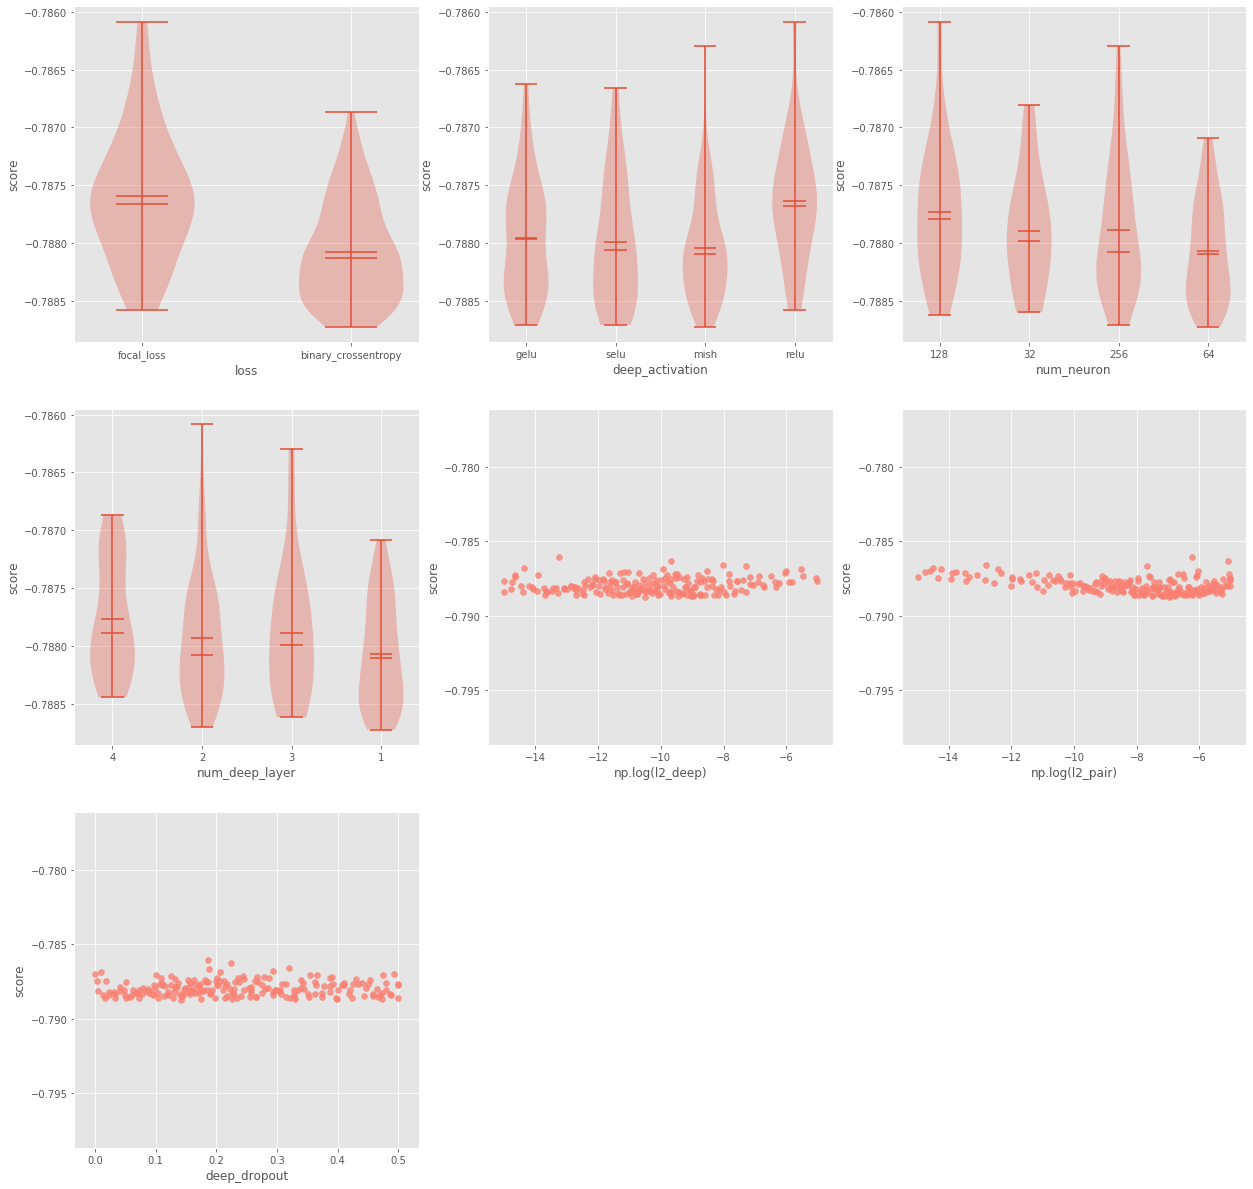

In [25]:
%matplotlib inline
tuning.log.plot(score_interval=[-0.79, -0.785])

# test best

In [15]:
%%time

batch_size = 8192
epochs = 100
nflod = 5

model_param = {'vocabulary_size':ecd.get_vocabulary(), 
               'feature_number': len(feature_col),
               'activation': 'sigmoid',
               'metrics': ['AUC'],
               'use_fm': True,
               'k': 5,
               'deep_use_bn': False,
               'optimizer': 'Adam',
               'deep_activation': 'mish',    
               'deep_dropout': 0.14131251282671942,    
               'l2_deep': 2.7626562843885004e-05,   
               'l2_pair': 0.0009439566996232189,   
               'loss': 'binary_crossentropy',   
               'num_deep_layer': 1,   
               'num_neuron': 64} 

clr = CyclicLR(base_lr=1e-5,
               max_lr = 1e-3, 
               step_size= int(4.0*(train_df.shape[0]*((nflod-1)/nflod)) / batch_size),
               mode='exp_range',
               gamma=1.0)

es = tf.keras.callbacks.EarlyStopping(monitor='val_AUC', patience=3, mode='max', restore_best_weights=True)

fit_param = {'batch_size': batch_size, 'epochs':epochs, 'verbose': 1, 'callbacks':[es, clr]}

model = deepfm(**model_param)

cv = CV(model, nflod)

score = cv.fit(x=[idx, val],
               y=y_train, 
               metrics_func=roc_auc_score,
               split_method=StratifiedKFold,
               fit_params=fit_param,
               eval_param={'batch_size':batch_size},
               use_proba=False, 
               verbose=True,
               fit_use_valid=True)

tf.keras.backend.clear_session()

Train on 480000 samples, validate on 120000 samples
Epoch 1/100
480000/480000 [==============================] - 4s 8us/sample - loss: 0.6982 - AUC: 0.5042 - val_loss: 0.6645 - val_AUC: 0.5185
Epoch 2/100
480000/480000 [==============================] - 2s 4us/sample - loss: 0.5811 - AUC: 0.5055 - val_loss: 0.4943 - val_AUC: 0.5674
Epoch 3/100
480000/480000 [==============================] - 2s 4us/sample - loss: 0.4792 - AUC: 0.6464 - val_loss: 0.4632 - val_AUC: 0.7492
Epoch 4/100
480000/480000 [==============================] - 2s 4us/sample - loss: 0.4435 - AUC: 0.7538 - val_loss: 0.4230 - val_AUC: 0.7701
Epoch 5/100
480000/480000 [==============================] - 2s 4us/sample - loss: 0.4162 - AUC: 0.7754 - val_loss: 0.4126 - val_AUC: 0.7802
Epoch 6/100
480000/480000 [==============================] - 2s 4us/sample - loss: 0.4105 - AUC: 0.7839 - val_loss: 0.4103 - val_AUC: 0.7841
Epoch 7/100
480000/480000 [==============================] - 2s 4us/sample - loss: 0.4081 - AUC: 0.787

480000/480000 [==============================] - 2s 4us/sample - loss: 0.4039 - AUC: 0.7930 - val_loss: 0.4076 - val_AUC: 0.7871
Epoch 6/100
480000/480000 [==============================] - 2s 4us/sample - loss: 0.4039 - AUC: 0.7928 - val_loss: 0.4072 - val_AUC: 0.7875
Epoch 7/100
480000/480000 [==============================] - 2s 4us/sample - loss: 0.4039 - AUC: 0.7923 - val_loss: 0.4067 - val_AUC: 0.7876
Epoch 8/100
480000/480000 [==============================] - 2s 4us/sample - loss: 0.4037 - AUC: 0.7919 - val_loss: 0.4059 - val_AUC: 0.7877
Epoch 9/100
480000/480000 [==============================] - 2s 4us/sample - loss: 0.4033 - AUC: 0.7913 - val_loss: 0.4050 - val_AUC: 0.7877
Epoch 10/100
480000/480000 [==============================] - 2s 4us/sample - loss: 0.4015 - AUC: 0.7927 - val_loss: 0.4043 - val_AUC: 0.7880
Epoch 11/100
480000/480000 [==============================] - 2s 4us/sample - loss: 0.3998 - AUC: 0.7946 - val_loss: 0.4038 - val_AUC: 0.7881
Epoch 12/100
480000/480

In [16]:
score

0.7886622486416439

# Final

In [ ]:
opt = tf.keras.optimizers.Adam(learning_rate=1e-4)

model = linear_regression(vocabulary_size=ecd.get_vocabulary(), 
                          feature_number=len(feature_col),, 
                          activation='sigmoid',
                          loss='mse',
                          metrics=['AUC'],
                          optimizer=opt, 
                          l1=0., l2=0.)

In [ ]:
callback = tf.keras.callbacks.EarlyStopping(monitor='val_AUC', patience=5, mode='max')
fit_param = {'batch_size':1024, 'epochs':20, 'verbose': 1, 'callbacks':[callback]}

In [ ]:
pred_param = {'batch_size':1024}

cv = CV(model, 5)

cv.fit(x=[idx, val],
       y=y_train, 
       metrics_func=roc_auc_score,
       split_method=StratifiedKFold,
       fit_params=fit_param,
       eval_param=pred_param,
       use_proba=False, 
       verbose=True,
       fit_use_valid=True)

In [ ]:
np.exp(-10)